#### Cadena de Pensamientos con RAG (Chain of Thoughts with RAG)

### ¿Qué es Chain-of-Thought (CoT) en RAG?

**CoT (Cadena de Pensamientos)** en RAG descompone una pregunta compleja en pasos intermedios, permitiendo recuperación + reflexión en cada paso antes de responder.

Este enfoque imita el razonamiento humano al dividir problemas complejos en sub-problemas más manejables.

### 🔄 Flujo de CoT RAG:

```
Consulta del Usuario
   ↓
Paso 1: Descomponer pregunta → sub-pasos (Razonar)
   ↓
Paso 2: Recuperar documentos por cada paso (Actuar)
   ↓
Paso 3: Combinar contexto (Observar)
   ↓
Paso 4: Generación de respuesta final (Reflexionar)
```

### 🎯 Ventajas de CoT RAG:
- ✅ Mejor manejo de preguntas complejas
- ✅ Razonamiento más transparente y explicable
- ✅ Recuperación más precisa por sub-pregunta
- ✅ Respuestas más fundamentadas y coherentes

In [1]:
# Importar librerías del sistema operativo
import os  # Para manejo de variables de entorno

# Importar tipos para anotaciones
from typing import List  # Para definir listas tipadas

# Importar Pydantic para validación de datos
from pydantic import BaseModel  # Clase base para modelos con validación automática

# Importar clases de LangChain
from langchain.schema import Document  # Clase para representar documentos

# Importar embeddings de OpenAI
from langchain_openai import OpenAIEmbeddings  # Modelo de embeddings para vectorización

# Importar cargadores de documentos
from langchain_community.document_loaders import TextLoader  # Cargador de archivos de texto

# Importar base de datos vectorial FAISS
from langchain.vectorstores import FAISS  # Vector store eficiente de Facebook

# Importar divisor de texto
from langchain.text_splitter import RecursiveCharacterTextSplitter  # División recursiva de documentos

# Importar componentes de LangGraph
from langgraph.graph import StateGraph, END  # StateGraph para grafos de estado, END para nodo final

c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------------
# 1. Preparar el Vectorstore (Base de Datos Vectorial)
# -------------------------------

# Cargar documentos desde archivo de texto con codificación UTF-8
# "research_notes.txt" contiene notas de investigación sobre transformers
docs = TextLoader("research_notes.txt", encoding="utf-8").load()

# Crear divisor de texto recursivo con parámetros específicos
# chunk_size=500: cada fragmento tendrá máximo 500 caracteres
# chunk_overlap=50: superposición de 50 caracteres entre fragmentos para mantener contexto
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Dividir los documentos en fragmentos (chunks) más pequeños
# Esto permite búsquedas más precisas y granulares
chunks = splitter.split_documents(docs)

# Inicializar el modelo de embeddings de OpenAI
# Este modelo convierte texto en vectores numéricos de alta dimensión
embedding = OpenAIEmbeddings()

# Crear base de datos vectorial FAISS a partir de los fragmentos
# FAISS indexa los embeddings para búsquedas de similitud rápidas
# from_documents() automáticamente genera embeddings y crea el índice
vectorstore = FAISS.from_documents(chunks, embedding)

# Convertir el vectorstore en un retriever (recuperador)
# El retriever proporciona una interfaz simple para búsquedas de similitud
retriever = vectorstore.as_retriever()

In [3]:
# Importar módulo os para variables de entorno
import os

# Importar función para inicializar modelos de chat de manera genérica
from langchain.chat_models import init_chat_model

# Importar load_dotenv para cargar variables desde archivo .env
from dotenv import load_dotenv

# Configurar la API key de OpenAI desde las variables de entorno
# Esto permite autenticar las solicitudes a la API de OpenAI
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Inicializar el modelo de lenguaje GPT-4o de OpenAI
# Este modelo será el "cerebro" que razona y genera respuestas
# init_chat_model permite usar diferentes proveedores con la misma interfaz
llm = init_chat_model("openai:gpt-4o")

In [4]:
# -------------------------------
# 2. Definición del Estado de LangGraph
# -------------------------------

# Definir la clase de estado para el sistema CoT RAG
# Esta clase hereda de BaseModel de Pydantic para validación automática
class RAGCoTState(BaseModel):
    """
    Estado que fluye a través del grafo de Chain-of-Thought RAG.
    
    Attributes:
        question: La pregunta compleja original del usuario
        sub_steps: Lista de sub-preguntas o pasos de razonamiento generados
        retrieved_docs: Lista de documentos recuperados para todos los sub-pasos
        answer: La respuesta final sintetizada
    """
    # La pregunta original completa del usuario
    question: str
    
    # Lista de sub-pasos o sub-preguntas para descomponer el problema
    # Se inicializa como lista vacía por defecto
    sub_steps: List[str] = []
    
    # Lista de todos los documentos recuperados de cada sub-paso
    # Se inicializa como lista vacía por defecto
    retrieved_docs: List[Document] = []
    
    # La respuesta final generada después del razonamiento CoT
    # Se inicializa como string vacío por defecto
    answer: str = ""

In [5]:
# -------------------------------
# 3. Nodos del Grafo CoT RAG
# -------------------------------

# a. Planificar sub-preguntas (Nodo Planner)
def plan_steps(state: RAGCoTState) -> RAGCoTState:
    """
    Descompone la pregunta compleja en 2-3 pasos de razonamiento.
    
    Este nodo es crucial para CoT porque:
    - Divide problemas complejos en partes manejables
    - Permite recuperación enfocada en cada aspecto
    - Facilita razonamiento paso a paso
    
    Args:
        state: Estado actual con la pregunta original
        
    Returns:
        Estado actualizado con sub_steps poblado
    """
    # Construir prompt que solicita al LLM descomponer la pregunta
    # Le pedimos explícitamente 2-3 pasos de razonamiento
    prompt = f"Divide la pregunta en 2-3 pasos de razonamiento: \n\n {state.question}"
    
    # Invocar el LLM con el prompt y obtener el contenido de la respuesta
    result = llm.invoke(prompt).content
    
    # Procesar la respuesta del LLM para extraer los sub-pasos
    # - split("\n"): divide por saltos de línea
    # - line.strip(): elimina espacios en blanco
    # - line.strip("- "): elimina guiones y espacios (formato de lista)
    # - if line.strip(): solo incluye líneas no vacías
    subqs = [line.strip("- ") for line in result.split("\n") if line.strip()]

    # Retornar estado actualizado con los sub-pasos
    # model_copy() crea una copia del estado con los campos actualizados
    return state.model_copy(update={"sub_steps": subqs})

In [6]:
# b. Recuperar documentos para cada paso (Nodo Retriever)
def retrieve_per_step(state: RAGCoTState) -> RAGCoTState:
    """
    Recupera documentos relevantes para cada sub-paso generado.
    
    Esta función implementa recuperación multi-paso:
    - Itera sobre cada sub-pregunta
    - Busca documentos relevantes para cada una
    - Acumula todos los documentos encontrados
    
    Args:
        state: Estado actual con sub_steps definidos
        
    Returns:
        Estado actualizado con retrieved_docs poblado
    """
    # Inicializar lista para acumular todos los documentos
    all_docs = []
    
    # Iterar sobre cada sub-paso de razonamiento
    for sub in state.sub_steps:
        # Invocar el retriever con el sub-paso como consulta
        # Esto busca documentos relevantes específicamente para este sub-paso
        docs = retriever.invoke(sub)
        
        # Agregar los documentos encontrados a la lista acumulada
        # extend() agrega todos los elementos de docs a all_docs
        all_docs.extend(docs)
    
    # Retornar estado actualizado con todos los documentos recuperados
    # Estos documentos servirán como contexto para la generación final
    return state.model_copy(update={"retrieved_docs": all_docs})

In [7]:
# c. Generar Respuesta Final (Nodo Responder)
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    """
    Sintetiza una respuesta final basada en el razonamiento CoT y documentos recuperados.
    
    Este nodo:
    - Combina todo el contexto recuperado
    - Usa la pregunta original y el contexto para generar respuesta
    - Produce una respuesta bien razonada y fundamentada
    
    Args:
        state: Estado con pregunta, sub_steps y retrieved_docs
        
    Returns:
        Estado actualizado con la respuesta final
    """
    
    # Construir el contexto concatenando el contenido de todos los documentos
    # "\n\n".join() une los textos con doble salto de línea para legibilidad
    # Iteramos sobre cada documento y extraemos su page_content
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    
    # Construir el prompt para generación final
    # Este prompt incluye:
    # 1. Instrucciones claras sobre el uso de razonamiento
    # 2. La pregunta original del usuario
    # 3. Todo el contexto recuperado de los sub-pasos
    # 4. Solicitud de síntesis razonada
    prompt = f"""
Estás respondiendo una pregunta compleja usando razonamiento y documentos recuperados.

Pregunta: {state.question}

Información Relevante:
{context}

Ahora sintetiza una respuesta final bien razonada.
"""
    
    # Invocar el LLM con el prompt construido
    # El LLM procesará toda la información y generará una respuesta coherente
    # .content extrae el texto de la respuesta
    # .strip() elimina espacios en blanco adicionales
    result = llm.invoke(prompt).content.strip()
    
    # Retornar estado actualizado con la respuesta final
    # Esta es la culminación del proceso CoT RAG
    return state.model_copy(update={"answer": result})

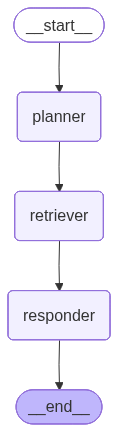

In [8]:
# -------------------------------
# 4. Construcción del Grafo LangGraph
# -------------------------------

# Inicializar el constructor del grafo con el esquema de estado RAGCoTState
# StateGraph gestiona el flujo de ejecución y la propagación del estado
builder = StateGraph(RAGCoTState)

# Agregar el nodo "planner" que ejecuta plan_steps
# Este nodo descompone la pregunta compleja en sub-pasos de razonamiento
builder.add_node("planner", plan_steps)

# Agregar el nodo "retriever" que ejecuta retrieve_per_step
# Este nodo recupera documentos relevantes para cada sub-paso
builder.add_node("retriever", retrieve_per_step)

# Agregar el nodo "responder" que ejecuta generate_answer
# Este nodo sintetiza la respuesta final basada en todo el contexto
builder.add_node("responder", generate_answer)

# Establecer "planner" como punto de entrada del grafo
# El flujo siempre comenzará descomponiendo la pregunta
builder.set_entry_point("planner")

# Agregar arista desde "planner" a "retriever"
# Después de planificar, se procede a recuperar documentos
builder.add_edge("planner", "retriever")

# Agregar arista desde "retriever" a "responder"
# Después de recuperar, se genera la respuesta final
builder.add_edge("retriever", "responder")

# Agregar arista desde "responder" a END
# Después de generar la respuesta, el grafo termina
builder.add_edge("responder", END)

# Compilar el grafo en un objeto ejecutable
# compile() valida y optimiza el grafo para ejecución
graph = builder.compile()

# Mostrar el grafo para visualizar su estructura
# Esto puede generar un diagrama del flujo: planner → retriever → responder → END
graph

In [9]:
# -------------------------------
# 5. Ejecutar el Agente CoT RAG
# -------------------------------

# Bloque principal que se ejecuta solo si el script se ejecuta directamente
if __name__ == "__main__":
    # Definir la consulta compleja del usuario
    # Esta pregunta es deliberadamente compleja y requiere razonamiento multi-paso
    # Nota: hay un typo en "eperiments" y "eveluation" (debería ser "experiments" y "evaluation")
    query = "¿Cuáles son los experimentos adicionales en la evaluación de Transformers?"
    
    # Crear el estado inicial del grafo
    # Inicializamos RAGCoTState con la pregunta del usuario
    # Los campos sub_steps, retrieved_docs y answer comenzarán vacíos
    state = RAGCoTState(question=query)
    
    # Ejecutar el grafo completo con el estado inicial
    # invoke() ejecuta el grafo de principio a fin:
    #   1. Nodo "planner": descompone la pregunta en sub-pasos
    #   2. Nodo "retriever": recupera documentos para cada sub-paso
    #   3. Nodo "responder": genera respuesta final sintetizada
    # Retorna el estado final con todos los campos completados
    final = graph.invoke(state)

    # Imprimir los pasos de razonamiento generados
    # Esto muestra cómo el sistema descompuso la pregunta compleja
    print("\n🪜 Pasos de Razonamiento:", final["sub_steps"])
    
    # Imprimir la respuesta final generada
    # Esta respuesta fue construida considerando todos los sub-pasos y documentos recuperados
    print("\n✅ Respuesta Final:\n", final["answer"])


🪜 Pasos de Razonamiento: ['Para abordar la pregunta sobre los experimentos adicionales en la evaluación de Transformers, podemos dividir el razonamiento en los siguientes pasos:', '1. **Identificar los objetivos de evaluación**:', 'Antes de diseñar experimentos adicionales, es fundamental entender qué aspectos específicos de los Transformers se quieren evaluar. Esto puede incluir la evaluación del rendimiento general en diferentes tareas de procesamiento de lenguaje natural, la eficiencia computacional, la capacidad de generalización, la interpretabilidad, etc.', '2. **Diseñar experimentos específicos**:', 'Con los objetivos en mente, se pueden diseñar experimentos específicos que aporten información adicional sobre el modelo. Esto podría incluir:', '**Análisis de robustez**: Probar el modelo con datos ruidosos, alterados o adversarios para evaluar su robustez.', '**Evaluaciones cruzadas de tareas**: Probar el modelo en tareas y dominios no vistos durante el entrenamiento para explora